In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from MFEA_lib.GA import population_init, factorial_cost, factorial_rank, skill_factor_best_task
from MFEA_lib.model.mfea import MFEA_base, AbstractModel, MFEA1
from MFEA_lib.model.utils import saveModel, loadModel, compareModel
from MFEA_lib.tasks.function import AbstractFunc
from MFEA_lib.operators import CrossOver, Mutation, Selection
from MFEA_lib.operators.CrossOver import SBX_CrossOver
from MFEA_lib.operators.Selection import ElitismSelection
from MFEA_lib.operators.Mutation import Polynomial_Mutation, NoMutation
from MFEA_lib.tasks.Benchmark import CEC17_benchmark, GECCO20_benchmark_50tasks

In [2]:
# class SA_MFEA(AbstractModel):
#     def renderRMP(self, title = None, figsize = None, dpi = 200):
#         #TODO
#         if figsize is None:
#             figsize = (30, 30)
#         if title is None:
#             title = self.__class__.__name__
#         fig = plt.figure(figsize= figsize, dpi = dpi)
#         fig.suptitle(title, size = 15)
#         fig.set_facecolor("white")

#         for i in range (len(self.tasks)):
#             for j in range (len(self.tasks)):
#                 r, c = min(i, j), max(i, j)
#                 if i != j: 
#                     plt.subplot(int(np.ceil(len(self.tasks) / 3)), 3, i + 1)
#                     plt.plot(np.arange(len(self.saved_rmp[r][c])), np.array(self.saved_rmp[r][c])[:, 0], label= 'task: ' +str(j + 1))
#                     plt.legend()
#                 else:
#                     plt.subplot(int(np.ceil(len(self.tasks) / 3)), 3, i + 1)
#                     plt.plot(np.arange(1000), np.ones_like(np.arange(1000)), label= 'task: ' +str(j + 1))
#                     plt.legend()




#             plt.title('task ' + str( i + 1))
#             plt.xlabel("Epoch")
#             plt.ylabel("M_rmp")
#             plt.ylim(bottom = -0.1, top = 1.1)

#         return fig

#     def success_history_memory_update(self, memory_M:np.ndarray, next_pos: np.ndarray, S: list, delta: list):
#         for i in range(len(self.tasks)):
#             for j in range(i+ 1, len(self.tasks)):
#                 if len(S[i][j]) != 0:
#                     memory_M[i, j][next_pos[i][j]] =\
#                         np.sum(np.array(delta[i][j]) * np.array(S[i][j])**2)/np.sum(np.array(delta[i][j]) * (np.array(S[i][j]))+ 1e-10)

#                     next_pos[i, j] = (next_pos[i, j] + 1) % memory_M.shape[2]
#         return memory_M, next_pos

#     def compile(self, cross_over = CrossOver.SBX_CrossOver(), mutation=  Mutation.Polynomial_Mutation(), selection= Selection.ElitismSelection()):
#         super().compile(cross_over, mutation, selection)
    
#     def fit(self, tasks: list[AbstractFunc], MAXEVALS, num_inds_each_task=100, nb_inds_min = None, H = 30, sigmoid = 0.1,
#                 evaluate_initial_skillFactor=True, range_init_pop= [0, 1]) -> tuple[list[np.ndarray], np.ndarray]:

#         # LSA or SA
#         if nb_inds_min is not None:
#             assert num_inds_each_task > nb_inds_min
#         else:
#             nb_inds_min = num_inds_each_task
            
#         self.tasks = tasks

#         # initial history of factorial cost -> for render
#         self.history_cost = np.empty((0, len(tasks)), np.float) 

#         # dim of Unified search space
#         dim_uss = max([t.dim for t in tasks])

#         # initial population
#         inf, sup = range_init_pop
#         population, skill_factor_arr = population_init(
#             N = num_inds_each_task,
#             num_tasks= len(tasks),
#             d = dim_uss,
#             min_val= inf,
#             max_val= sup
#         )

#         if evaluate_initial_skillFactor:
#             skill_factor_arr = skill_factor_best_task(population, tasks)
#         pop_fcost = factorial_cost(population, skill_factor_arr, tasks)
#         pop_fitness = 1/factorial_rank(pop_fcost, skill_factor_arr, len(tasks))

#         # SA params:
#         eval_k = np.zeros(len(tasks))
#         max_Eval = int(MAXEVALS / len(tasks))
#         epoch = 0

#         # Initial success hitory memory M
#         memory_M = np.ones((len(tasks), len(tasks), H))/2
#         next_update_pos_M = np.zeros((len(tasks), len(tasks)), np.int)

#         # mean and std of rmp each generations
#         # len(tasks) * len(tasks) * generations * 2
#         self.saved_rmp = np.array([[[[0.5, 0]]]* len(tasks)] * len(tasks)).tolist()

#         # save history_cost
#         self.history_cost = np.append(self.history_cost, 
#             [[np.min(pop_fcost[np.where(skill_factor_arr == idx)[0]]) for idx in range (len(tasks))]], 
#             axis = 0
#         )

#         while np.sum(eval_k) < MAXEVALS:
            
#             S = np.empty((len(tasks), len(tasks), 0)).tolist()
#             delta = np.empty((len(tasks), len(tasks), 0)).tolist()

#             # initial offspring of generation
#             offspring = np.empty((0, dim_uss))
#             offspring_skill_factor = np.empty((0, ), np.int)
#             offspring_fcost = np.empty((0, ))

#             # hisory rmp of this generation
#             rmp_this_gen = np.empty((len(tasks), len(tasks), 0)).tolist()

#             while len(offspring) < len(population):
#                 [idx_pa, idx_pb] = np.random.choice(len(population), size= 2, replace= False)
#                 [pa, pb], [skf_pa, skf_pb] = population[[idx_pa, idx_pb]], skill_factor_arr[[idx_pa, idx_pb]]

#                 if skf_pa == skf_pb:
#                     # Intra-crossover + mutate
#                     oa, ob = self.cross_over(pa, pb, type= 'intra')
#                     oa, ob = self.mutation(oa), self.mutation(ob)
#                     skf_oa, skf_ob = skf_pa, skf_pa

#                     # Evaluate oa, ob
#                     fcost_oa, fcost_ob = tasks[skf_oa].func(oa), tasks[skf_ob].func(ob)
#                     eval_k[skf_oa] += 1
#                     eval_k[skf_ob] += 1
                
#                 else:
#                     # swap
#                     if skf_pa > skf_pb:
#                         pa, pb = pb, pa
#                         skf_pa, skf_pb = skf_pb, skf_pa

#                     # get rmp
#                     mu = np.random.choice(memory_M[skf_pa, skf_pb])
#                     # rmp = np.random.normal(mu, sigmoid)
#                     #bro Thang's random
#                     rmp = mu + sigmoid * np.sqrt(-2.0 * np.log(np.random.uniform()))\
#                         * np.sin(2.0 * np.pi * np.random.uniform())

#                     if rmp < 0: rmp = 0
#                     if rmp > 1: rmp = 1

#                     # save generation's rmp
#                     rmp_this_gen[skf_pa][skf_pb].append(rmp)

#                     # Inter-TaskCrossover
#                     if np.random.uniform() < rmp:
#                         oa, ob = self.cross_over(pa, pb, type= 'inter')
#                         oa, ob = self.mutation(oa), self.mutation(ob)
#                         skf_oa, skf_ob = np.random.choice([skf_pa, skf_pb], size= 2, replace= True)
#                     else:
#                         # select pa' and pb'
#                         idx_pa2 = np.random.choice(np.where(skill_factor_arr == skf_pa)[0])
#                         while idx_pa2 == idx_pa:
#                             idx_pa2 = np.random.choice(np.where(skill_factor_arr == skf_pa)[0])
#                         idx_pb2 = np.random.choice(np.where(skill_factor_arr == skf_pb)[0])
#                         while idx_pb2 == idx_pb:
#                             idx_pb2 = np.random.choice(np.where(skill_factor_arr == skf_pb)[0])

#                         pa2 = population[idx_pa2]
#                         pb2 = population[idx_pb2]

#                         # NOTE
#                         # oa, _ = self.cross_over(pa, pa2, type= 'intra')
#                         # ob, _ = self.cross_over(pb, pb2, type= 'intra')
#                         oa, ob = self.cross_over(pa, pa2, type= 'intra')

#                         oa, ob = self.mutation(oa), self.mutation(ob)
                        
#                         #NOTE
#                         skf_oa, skf_ob = skf_pa, skf_pa
                    
#                     # Evaluate oa, ob
#                     fcost_oa, fcost_ob = tasks[skf_oa].func(oa), tasks[skf_ob].func(ob)
#                     eval_k[skf_oa] += 1
#                     eval_k[skf_ob] += 1
                    
#                     # Calculate the maximum improvement percetage
#                     Delta = 0
#                     if skf_oa == skf_pa:
#                         Delta = max(Delta, 
#                             (pop_fcost[idx_pa] - fcost_oa)/(pop_fcost[idx_pa] + 1e-10)
#                         )
#                     else:
#                         Delta = max(Delta, 
#                             (pop_fcost[idx_pb] - fcost_oa)/(pop_fcost[idx_pb]+ 1e-10)
#                         )
#                     if skf_ob == skf_pa:
#                         Delta = max(Delta, 
#                             (pop_fcost[idx_pa] - fcost_ob)/(pop_fcost[idx_pa]+ 1e-10)
#                         )
#                     else:
#                         Delta = max(Delta, 
#                             (pop_fcost[idx_pb] - fcost_ob)/(pop_fcost[idx_pb]+ 1e-10)
#                         )
                    
#                     if Delta > 0:
#                         S[skf_pa][skf_pb].append(rmp)
#                         delta[skf_pa][skf_pb].append(Delta)
                
#                 offspring = np.append(offspring, [oa, ob], axis = 0)
#                 offspring_skill_factor = np.append(offspring_skill_factor, [skf_oa, skf_ob], axis = 0)
#                 offspring_fcost = np.append(offspring_fcost, [fcost_oa, fcost_ob], axis = 0)

#             # update succes history memory 
#             memory_M, next_update_pos_M = self.success_history_memory_update(memory_M, next_update_pos_M, S, delta)

#             # merge
#             population = np.append(population, offspring, axis = 0)
#             skill_factor_arr = np.append(skill_factor_arr, offspring_skill_factor, axis = 0)
#             pop_fcost = np.append(pop_fcost, offspring_fcost, axis = 0)

#             # selection
#             pop_fitness = 1/factorial_rank(pop_fcost, skill_factor_arr, len(tasks))
#             nb_inds_tasks = min(((nb_inds_min - num_inds_each_task)/max_Eval * eval_k + num_inds_each_task).tolist(), [num_inds_each_task] * len(tasks))
#             idx = self.selection(skill_factor_arr, pop_fitness, nb_inds_tasks= nb_inds_tasks)

#             population = population[idx]
#             skill_factor_arr = skill_factor_arr[idx]
#             pop_fcost = pop_fcost[idx]

#             #save history
#             self.history_cost = np.append(self.history_cost, 
#                 [[np.min(pop_fcost[np.where(skill_factor_arr == idx)[0]]) for idx in range (len(tasks))]], 
#                 axis = 0
#             )     

#             # save mean and std rmp
#             for i in range(len(tasks)):
#                 for j in range(i + 1, len(tasks)):
#                     if len(rmp_this_gen[i][j]) != 0:
#                         mu = np.mean(rmp_this_gen[i][j])
#                         std = np.std(rmp_this_gen[i][j])
#                         self.saved_rmp[i][j].append([mu, std])

#             #print
#             sys.stdout.write('\r')
#             sys.stdout.write('Epoch {}, [%-20s] %3d%% ,pop_size: {}, func_val: {}'
#                 .format(epoch + 1, len(population),[np.min(pop_fcost[np.where(skill_factor_arr == idx)[0]]) for idx in range (len(tasks))])
#                 % ('=' * np.int((np.sum(eval_k) + 1) // (MAXEVALS // 20)) + '>' , (np.sum(eval_k) + 1) * 100 // MAXEVALS)
#                 )
#             sys.stdout.flush()

#             epoch += 1

#         #solve
#         sol_idx = [np.argmin(pop_fcost[np.where(skill_factor_arr == idx)]) for idx in range (len(tasks))]
#         self.solve = [task.decode(population[np.where(skill_factor_arr == idx)][sol_idx[idx]]) for idx, task in enumerate(tasks)]

#         return self.solve, self.history_cost


In [3]:
class cus_MFEA(AbstractModel):
    def renderRMP(self, title = None, figsize = None, dpi = 200):
        if figsize is None:
            figsize = (30, 30)
        if title is None:
            title = self.__class__.__name__
        fig = plt.figure(figsize= figsize, dpi = dpi)
        fig.suptitle(title, size = 15)
        fig.set_facecolor("white")

        for i in range (len(self.tasks)):
            for j in range (len(self.tasks)):
                if i != j: 
                    plt.subplot(int(np.ceil(len(self.tasks) / 3)), 3, i + 1)
                    plt.plot(np.arange(len(self.saved_rmp[i][j])), np.array(self.saved_rmp[i][j])[:, 0], label= 'task: ' +str(j + 1))
                    plt.legend()
                else:
                    plt.subplot(int(np.ceil(len(self.tasks) / 3)), 3, i + 1)
                    plt.plot(np.arange(1000), np.ones_like(np.arange(1000)), label= 'task: ' +str(j + 1))
                    plt.legend()

            plt.title('task ' + str( i + 1))
            plt.xlabel("Epoch")
            plt.ylabel("M_rmp")
            plt.ylim(bottom = -0.1, top = 1.1)

        return fig

    def success_history_memory_update(self, memory_M:np.ndarray, next_pos: np.ndarray, S: list, delta: list):
        for i in range(len(self.tasks)):
            for j in range(len(self.tasks)):
                if len(S[i][j]) != 0:
                    memory_M[i, j][next_pos[i][j]] =\
                        np.sum(np.array(delta[i][j]) * np.array(S[i][j])**2)/np.sum(np.array(delta[i][j]) * (np.array(S[i][j]))+ 1e-10)

                    next_pos[i, j] = (next_pos[i, j] + 1) % memory_M.shape[2]
        return memory_M, next_pos
    
    def findParent(self, idx_parents, pop_fcost, type = None):
        if type == 'intra':
            idx_p1, idx_p2 = np.random.choice(idx_parents, size= 2, replace= False)
            return (idx_p1, idx_p2)[np.argmin([pop_fcost[idx_p1], pop_fcost[idx_p2]])]
        elif type == 'inter':
            idx = np.random.choice(idx_parents)
            return idx
        else:
            raise ValueError()

    def compile(self, cross_over = CrossOver.SBX_CrossOver(), mutation=  Mutation.Polynomial_Mutation(), selection= Selection.ElitismSelection()):
        super().compile(cross_over, mutation, selection)
    
    def fit(self, tasks: list[AbstractFunc], num_epochs, num_inds_each_task=100, nb_inds_min = None, H = 30, sigmoid = 0.1,
                evaluate_initial_skillFactor=True, range_init_pop= [0, 1]) -> tuple[list[np.ndarray], np.ndarray]:

        # LSA or SA
        if nb_inds_min is not None:
            assert num_inds_each_task >= nb_inds_min
        else:
            nb_inds_min = num_inds_each_task
            
        self.tasks = tasks

        # initial history of factorial cost -> for render
        self.history_cost = np.empty((0, len(tasks)), np.float) 

        # dim of Unified search space
        dim_uss = max([t.dim for t in tasks])

        # initial population
        inf, sup = range_init_pop
        population, skill_factor_arr = population_init(
            N = num_inds_each_task,
            num_tasks= len(tasks),
            d = dim_uss,
            min_val= inf,
            max_val= sup
        )

        if evaluate_initial_skillFactor:
            skill_factor_arr = skill_factor_best_task(population, tasks)
        pop_fcost = factorial_cost(population, skill_factor_arr, tasks)
        pop_fitness = 1/factorial_rank(pop_fcost, skill_factor_arr, len(tasks))

        # Initial success history memory M_rmp
        M_rmp = np.ones((len(tasks), len(tasks), H))/2
        next_update_pos_M_rmp = np.zeros((len(tasks), len(tasks)), np.int)

        # NOTE
        # Initial success history memory M_p_swap_inter - M_psi
        M_psi = np.ones((len(tasks), len(tasks), H))/10
        next_update_pos_M_psi = np.zeros((len(tasks), len(tasks)), np.int)

        # mean and std of rmp each generations
        # len(tasks) * len(tasks) * generations * 2
        self.saved_rmp = np.array([[[[0.5, 0]]]* len(tasks)] * len(tasks)).tolist()

        # save history_cost
        self.history_cost = np.append(self.history_cost, 
            [[np.min(pop_fcost[np.where(skill_factor_arr == idx)[0]]) for idx in range (len(tasks))]], 
            axis = 0
        )

        for epoch in range(num_epochs):
            # NOTE S, delta psi
            S_psi = np.empty((len(tasks), len(tasks), 0)).tolist()
            delta_psi = np.empty((len(tasks), len(tasks), 0)).tolist()

            # S, delta rmp
            S_rmp = np.empty((len(tasks), len(tasks), 0)).tolist()
            delta_rmp = np.empty((len(tasks), len(tasks), 0)).tolist()

            # initial offspring of generation
            offspring = np.empty((0, dim_uss))
            offspring_skill_factor = np.empty((0, ), np.int)
            offspring_fcost = np.empty((0, ))

            # hisory rmp of this generation
            rmp_this_gen = np.empty((len(tasks), len(tasks), 0)).tolist()

            while len(offspring) < len(population):
                skf_pa, skf_pb = np.random.choice(np.arange(len(tasks)), size = 2, replace= False)          

                # get rmp
                mu = np.random.choice(M_rmp[skf_pa, skf_pb])
                rmp = -1
                while rmp <= 0:
                    rmp = np.random.normal(mu, sigmoid)
                if rmp > 1: rmp = 1

                # save generation's rmp
                rmp_this_gen[skf_pa][skf_pb].append(rmp)

                # Inter-TaskCrossover
                if np.random.uniform() < rmp * (len(tasks) - 1)/len(tasks):
                    # NOTE get p_swap_inter
                    mu_psi = np.random.choice(M_psi[skf_pa, skf_pb])
                    psi = np.random.normal(mu_psi, 0.05)
                    while psi <= 0: psi = np.random.normal(mu_psi, 0.05)
                    if psi > 1: psi = 1
                    
                    #find parent
                    idx_pa = self.findParent(np.where(skill_factor_arr == skf_pa)[0], pop_fcost, type = 'inter')
                    idx_pb = self.findParent(np.where(skill_factor_arr == skf_pb)[0], pop_fcost, type = 'inter')

                    pa, pb = population[idx_pa], population[idx_pb]

                    # NOTE not use psi
                    oa, ob = self.cross_over(pa, pb, type= ('inter1skf', psi))
                    oa, ob = self.mutation(oa), self.mutation(ob)
                    skf_oa, skf_ob = skf_pa, skf_pa

                    # Evaluate oa, ob
                    fcost_oa, fcost_ob = tasks[skf_oa].func(oa), tasks[skf_ob].func(ob)

                    # Calculate the maximum improvement percetage
                    Delta = max(0, 
                        (pop_fcost[idx_pa] - fcost_oa)/(pop_fcost[idx_pa] + 1e-10),
                        (pop_fcost[idx_pa] - fcost_ob)/(pop_fcost[idx_pa] + 1e-10)
                    )

                    # NOTE save psi
                    if Delta > 0:
                        S_psi[skf_pa][skf_pb].append(psi)
                        delta_psi[skf_pa][skf_pb].append(Delta)
                # Intra-TaskCrossover
                else:
                    idx_pa = self.findParent(np.where(skill_factor_arr == skf_pa)[0], pop_fcost, type = 'intra')
                    idx_pa2 = self.findParent(np.where(skill_factor_arr == skf_pa)[0], pop_fcost, type = 'intra')

                    pa, pa2 = population[idx_pa], population[idx_pa2]

                    oa, ob = self.cross_over(pa, pa2, type= 'intra')
                    oa, ob = self.mutation(oa), self.mutation(ob)
                    skf_oa, skf_ob = skf_pa, skf_pa

                    # Evaluate oa, ob
                    fcost_oa, fcost_ob = tasks[skf_oa].func(oa), tasks[skf_ob].func(ob)

                    # Calculate the maximum improvement percetage
                    Delta = max(0, 
                            (min(pop_fcost[idx_pa], pop_fcost[idx_pa2]) - fcost_oa)/(min(pop_fcost[idx_pa], pop_fcost[idx_pa2]) + 1e-10),
                            (min(pop_fcost[idx_pa], pop_fcost[idx_pa2]) - fcost_ob)/(min(pop_fcost[idx_pa], pop_fcost[idx_pa2]) + 1e-10)
                    )
                    
                if Delta > 0:
                    S_rmp[skf_pa][skf_pb].append(rmp)
                    delta_rmp[skf_pa][skf_pb].append(Delta)
                
                offspring = np.append(offspring, [oa, ob], axis = 0)
                offspring_skill_factor = np.append(offspring_skill_factor, [skf_oa, skf_ob], axis = 0)
                offspring_fcost = np.append(offspring_fcost, [fcost_oa, fcost_ob], axis = 0)

            # update succes history memory 
            M_rmp, next_update_pos_M_rmp = self.success_history_memory_update(M_rmp, next_update_pos_M_rmp, S_rmp, delta_rmp)

            # NOTE update psi
            M_psi, next_update_pos_M_psi = self.success_history_memory_update(M_psi, next_update_pos_M_psi, S_psi, delta_psi)

            # merge
            population = np.append(population, offspring, axis = 0)
            skill_factor_arr = np.append(skill_factor_arr, offspring_skill_factor, axis = 0)
            pop_fcost = np.append(pop_fcost, offspring_fcost, axis = 0)

            # selection
            pop_fitness = 1/factorial_rank(pop_fcost, skill_factor_arr, len(tasks))
            nb_inds_tasks = [int(min((nb_inds_min - num_inds_each_task)/num_epochs * epoch + num_inds_each_task, num_inds_each_task))]*len(tasks)
            idx = self.selection(skill_factor_arr, pop_fitness, nb_inds_tasks= nb_inds_tasks)

            population = population[idx]
            skill_factor_arr = skill_factor_arr[idx]
            pop_fcost = pop_fcost[idx]

            #save history
            self.history_cost = np.append(self.history_cost, 
                [[np.min(pop_fcost[np.where(skill_factor_arr == idx)[0]]) for idx in range (len(tasks))]], 
                axis = 0
            )     

            # save mean and std rmp
            for i in range(len(tasks)):
                for j in range(len(tasks)):
                    if len(rmp_this_gen[i][j]) != 0:
                        mu = np.mean(rmp_this_gen[i][j])
                        std = np.std(rmp_this_gen[i][j])
                        self.saved_rmp[i][j].append([mu, std])

            #print
            sys.stdout.write('\r')
            sys.stdout.write('Epoch {}, [%-20s] %3d%% ,pop_size: {}, func_val: {}'
                .format(epoch + 1, len(population),[np.min(pop_fcost[np.where(skill_factor_arr == idx)[0]]) for idx in range (len(tasks))])
                % ('=' * np.int((np.sum(epoch) + 1) // (num_epochs // 20)) + '>' , (np.sum(epoch) + 1) * 100 // num_epochs)
                )
            sys.stdout.flush()

            epoch += 1

        #solve
        sol_idx = [np.argmin(pop_fcost[np.where(skill_factor_arr == idx)]) for idx in range (len(tasks))]
        self.solve = [task.decode(population[np.where(skill_factor_arr == idx)][sol_idx[idx]]) for idx, task in enumerate(tasks)]

        return self.solve, self.history_cost


In [4]:
cec17_10tasks = CEC17_benchmark.get_10tasks_benchmark()

In [5]:
cus_model = cus_MFEA()

cus_model.compile(
    cross_over= SBX_CrossOver(nc = 2),
    # mutation= Polynomial_Mutation(nm = 5),
    mutation = NoMutation(),
    selection= ElitismSelection()
)

cus_sol, cus_his = cus_model.fit(tasks= cec17_10tasks, num_epochs= 1000, num_inds_each_task= 100, nb_inds_min = 100, H = 30, sigmoid = 0.1,
                    evaluate_initial_skillFactor= True)
saveModel(cus_model, "./RESULTS/cec17_cusMFEA2.mso")


Epoch 1000, [====================>] 100% ,pop_size: 1000, func_val: [4.10550599278934e-21, 7.423639036107984e-22, 3.0453817473876117e-25, 0.0, 156.25599542856116, 9.123812816369536e-12, 0.0, 5379.9708332788105, 0.0, 63.67728888235092]]].67728888235092]]]]3.677288882351036]]728995763957]7]6]

'Saved'

In [6]:
model1 = loadModel("./RESULTS/cec17_mfea1.mso")

base_model = loadModel("./RESULTS/cec17_mfeabase.mso")

sa_model = loadModel("./RESULTS/cec17_sa_mfea.mso")

lsa_model = loadModel("./RESULTS/cec17_lsa_mfea.mso")

cus_model:cus_MFEA = loadModel("./RESULTS/cec17_cusMFEA2.mso")

AttributeError: Can't get attribute 'SA_MFEA' on <module '__main__'>

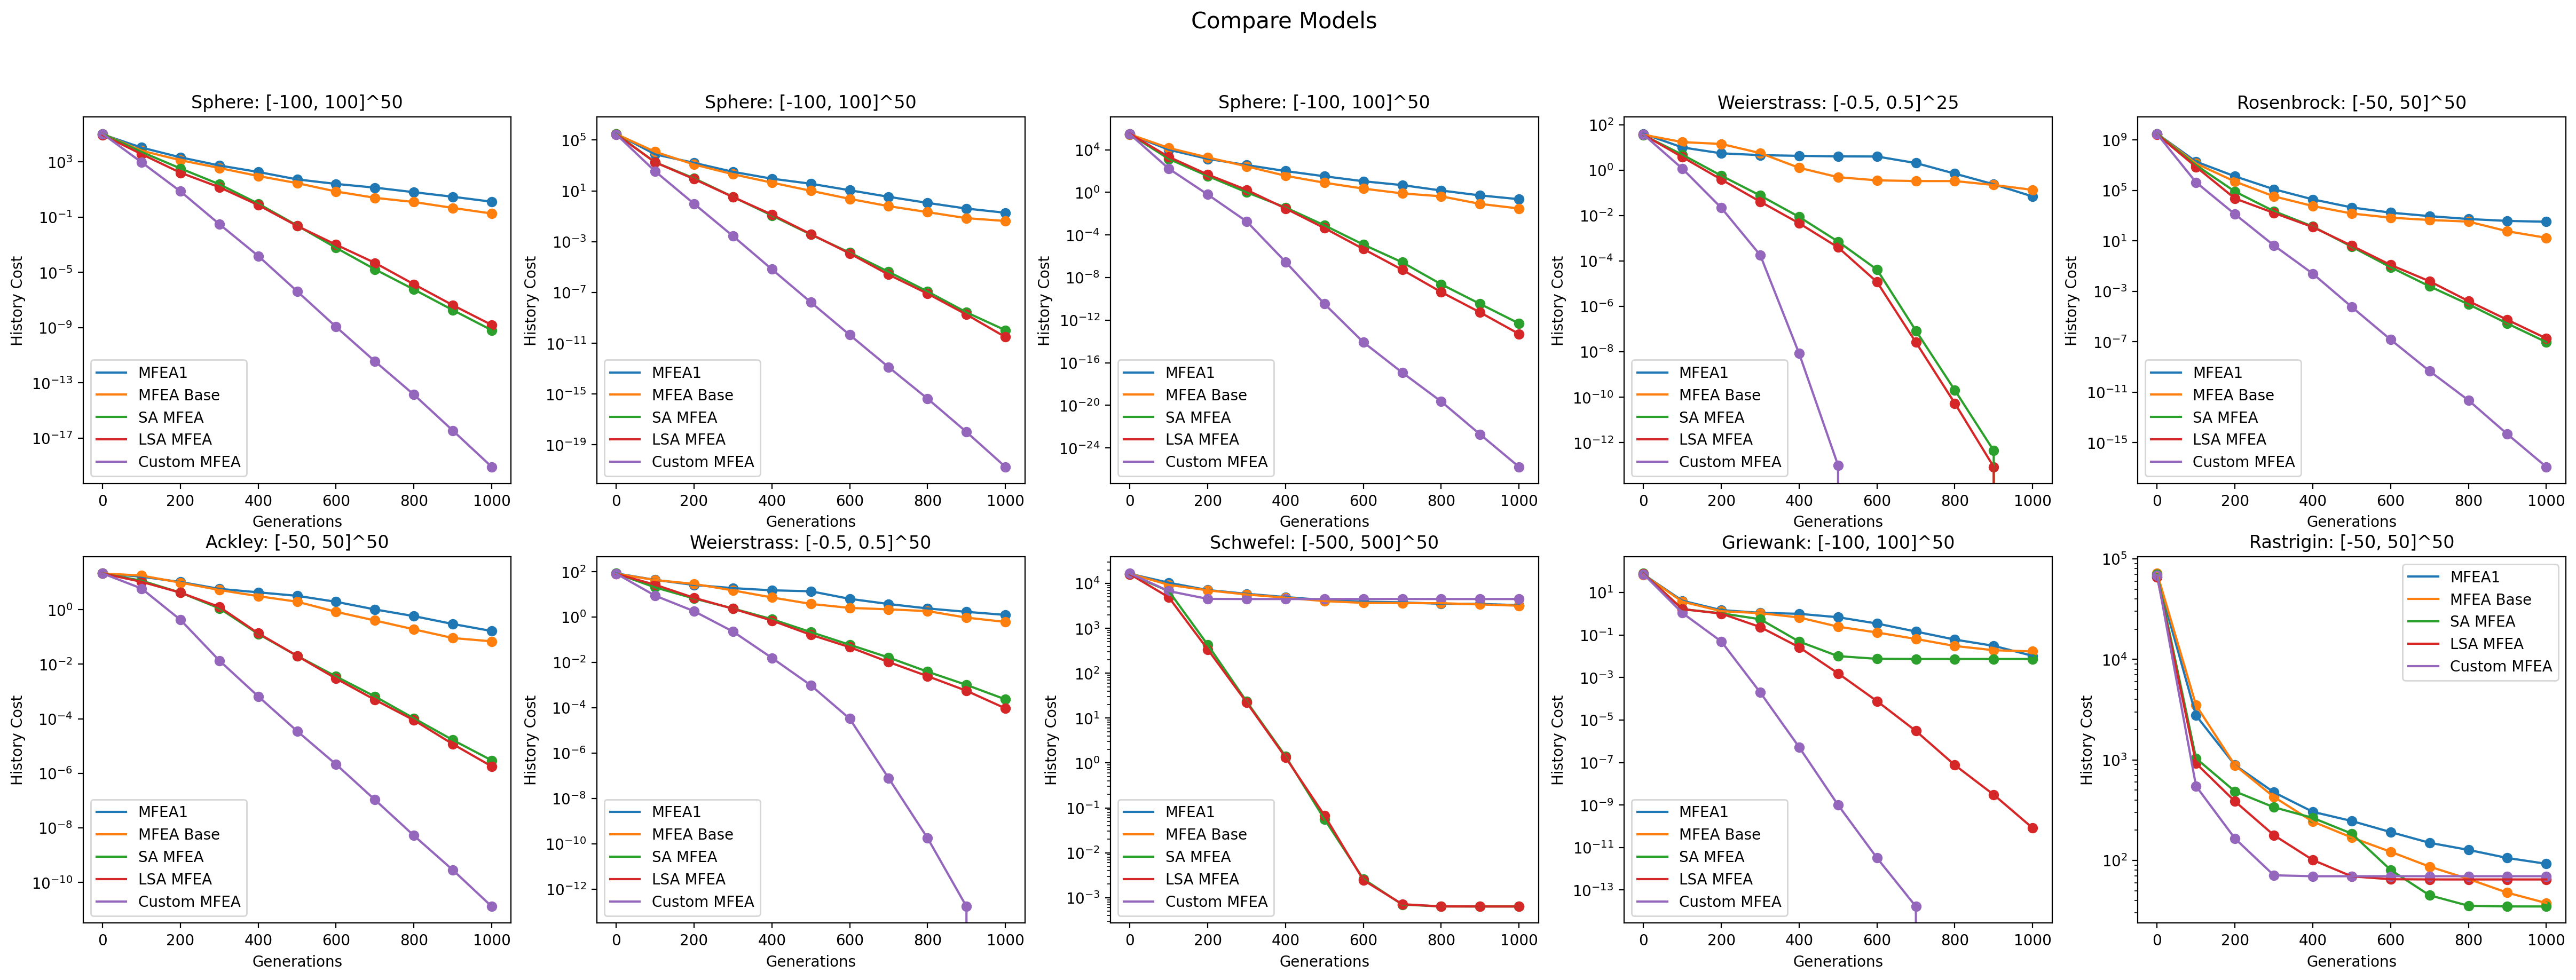

In [ ]:
compareModel(
    models= [model1, base_model, sa_model, lsa_model, cus_model],
    label_legend=  ["MFEA1", "MFEA Base", "SA MFEA", "LSA MFEA", "Custom MFEA"],
    tasks= cec17_10tasks,
    shape= (2, 5),
    step= 100,
    yscale= 'log'
)
print()

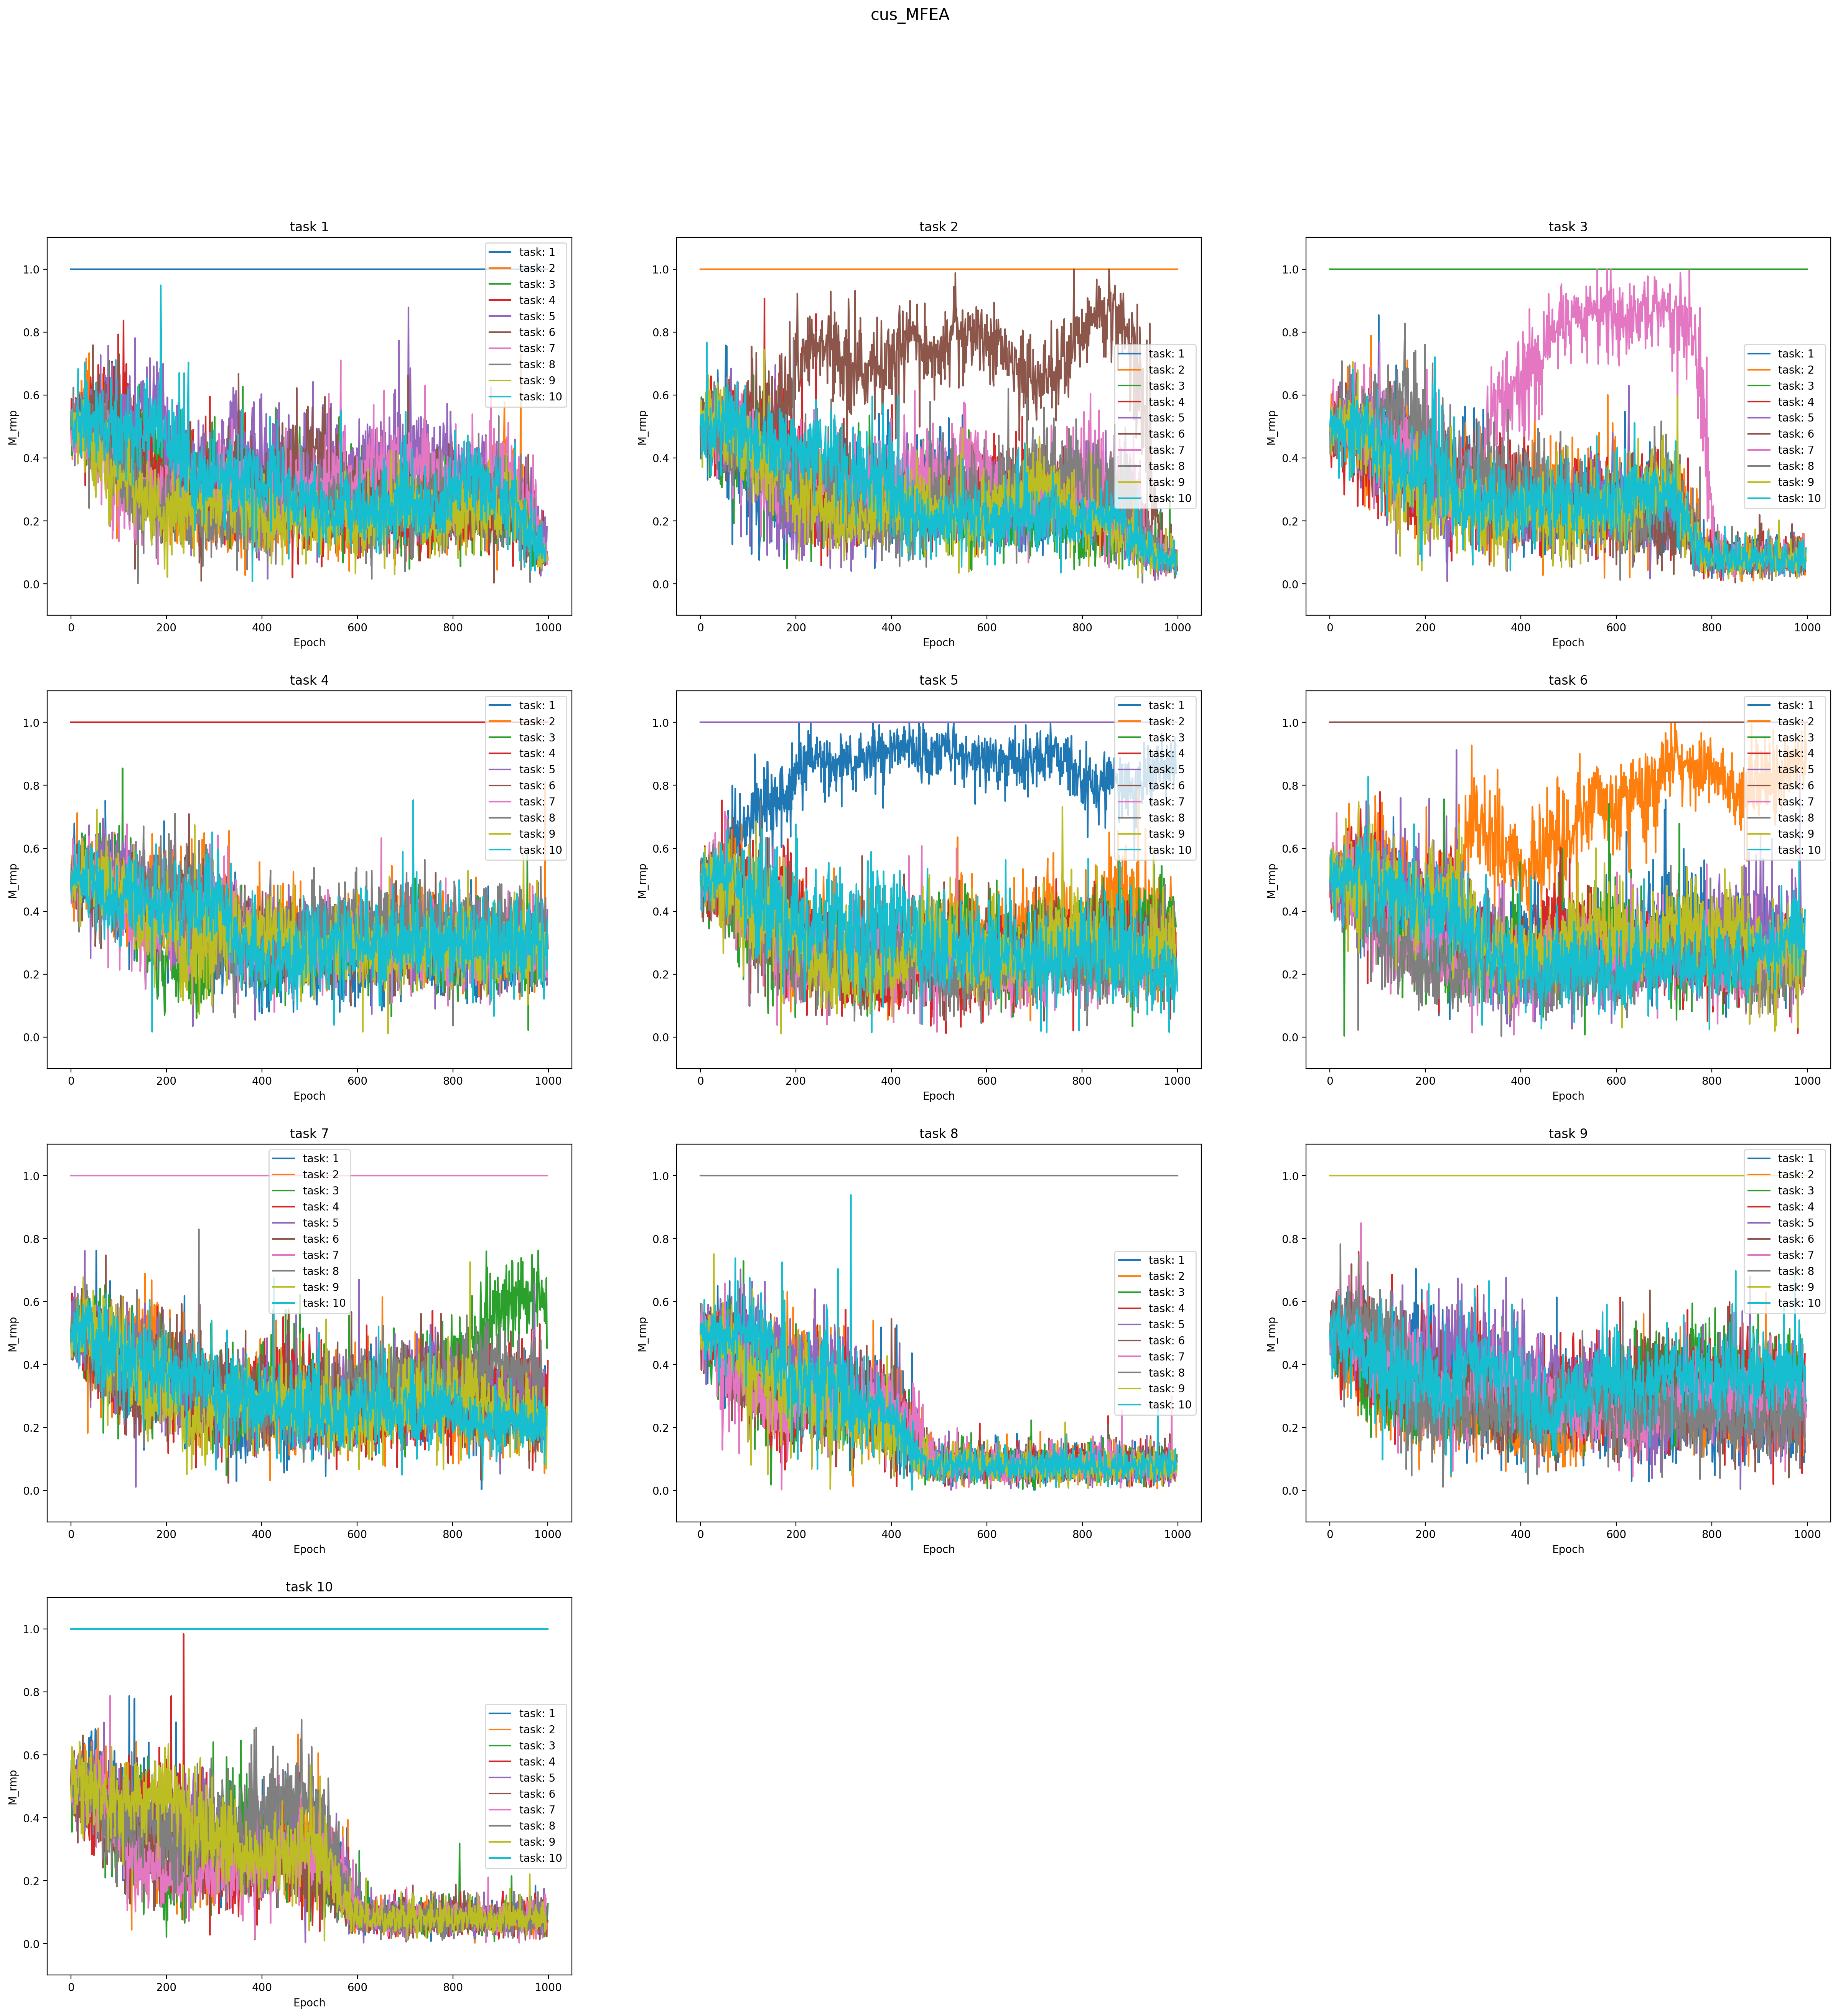

In [ ]:
cus_model.renderRMP()
print()